In [1]:
# import libraries 
import pandas as pd
from sklearn.cluster import KMeans
from sklearn_extra.cluster import CLARA
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
import numpy as np
import matplotlib.patches as mpatches
import seaborn as sns
import skfuzzy as fuzz
import pickle
from sklearn.metrics import silhouette_score, davies_bouldin_score
from sklearn.model_selection import GridSearchCV

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=DeprecationWarning)

In [2]:
my_colors = ['#88292F', '#697268', '#12355B', '#D7816A', '#e8da6f', '#c33b43', 
               '#9DBF9E', '#64a0e0', '#343934', '#280003','#cd5a61', '#913d27', 
               '#F46036', '#248232',  '#bea602', '#0a6682', '#646536', '#624763', '#2F1847', 
               '#FF7B9C', '#66A182', '#94849B', '#ACD8AA', '#F48498', '#B30089']
custom_cmap = LinearSegmentedColormap.from_list('custom_cmap', my_colors)

In [3]:
pca_df = pd.read_csv('pca_df.csv')
pca_to_plot_df = pd.read_csv('pca_to_plot_df.csv')
df_subset = pd.read_csv('df_subset.csv')

In [4]:
def clustering_score(estimator, X, silhouette_weight=0.5, davies_bouldin_weight=0.5):
    labels = estimator.fit_predict(X)
    silhouette = silhouette_score(X, labels)
    davies_bouldin = davies_bouldin_score(X, labels)
    final_score = silhouette_weight * silhouette + davies_bouldin_weight * davies_bouldin
    return final_score

# Partition Clustering

## K-Means

In [5]:
# # Define the parameter grid
# param_grid = {
#     'n_clusters': [2, 3, 4, 5, 10],
# }

# k_means_clust = KMeans(random_state=1)

# # Initialize GridSearchCV
# grid_search = GridSearchCV(k_means_clust, param_grid, scoring=silhouette_scorer, cv=2, verbose=2, n_jobs=-1)

# # Perform grid search
# grid_search.fit(pca_df)

In [6]:
# # Get the best parameters
# best_params = grid_search.best_params_
# print("Best Parameters:", best_params)

# # Get the best silhouette score
# best_score = grid_search.best_score_
# print("Best Silhouette Score:", best_score)

In [5]:
kmeans = KMeans(n_clusters=5, random_state=1)
kmeans.fit(pca_df)

# Get cluster labels
cluster_labels = kmeans.labels_

In [6]:
with open('results/partitional_opt/kmeans_model.pickle', 'wb') as f:
    pickle.dump(kmeans, f)

In [7]:
with open('results/partitional_opt/kmeans_model.pickle', 'rb') as f:
    kmeans = pickle.load(f)

In [8]:
cluster_labels = kmeans.labels_

In [9]:
pca_to_plot_df['cluster'] = cluster_labels
pca_to_plot_df['asset_id'] = df_subset['asset_id']

pca_df['cluster'] = cluster_labels
pca_df['asset_id'] = df_subset['asset_id']

In [10]:
pca_df.to_csv('results/partitional_opt/csv_labels_raw/kmeans.csv', index=False)

In [11]:
pca_df=  pca_df.loc[:,:'PC4']

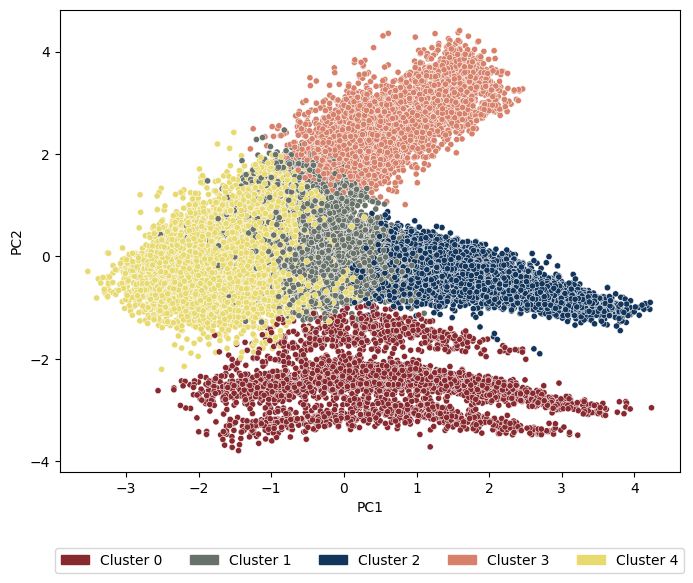

In [12]:
n_clusters = len(pca_to_plot_df['cluster'].unique())
pallete = sns.color_palette(my_colors, n_clusters)

# Plot the representative points on a scatter plot using PCA results
plt.figure(figsize=(8, 6))
sns.scatterplot(data=pca_to_plot_df, x='PC1', y='PC2', hue='cluster', palette=pallete, s=20)
# plt.title('K-Means')
plt.xlabel('PC1')
plt.ylabel('PC2')
legend_handles = [mpatches.Circle((0, 0), radius=1, color=color) for color in my_colors]
plt.legend(handles=legend_handles, labels=[f'Cluster {cluster_label}' for cluster_label in np.unique(cluster_labels)],
            loc='upper center', bbox_to_anchor=(0.5, -0.15), ncol=5)
plt.show()

In [13]:
most_frequent_clusters = pca_to_plot_df.groupby('asset_id')['cluster'].agg(lambda x: np.bincount(x).argmax())

# Merge the most frequent cluster labels back to the original DataFrame
pca_to_plot_df = pca_to_plot_df.drop(columns='cluster')

pca_to_plot_df = pd.merge(pca_to_plot_df, most_frequent_clusters, on='asset_id', how='left')

pca_to_plot_df.head()

,PC1,PC2,asset_id,cluster
0,-1.163049,-2.596939,11,0
1,1.722822,-2.602608,11,0
2,1.451641,-2.588719,11,0
3,0.734407,-2.237956,11,0
4,0.121023,-2.182634,11,0


In [14]:
pca_to_plot_df.to_csv('results/partitional_opt/labels_most_common/k_means.csv', index = False)

In [15]:
# Group by asset_id and cluster, and select one representative point for each cluster
representative_points = pca_to_plot_df.groupby(['asset_id']).first().reset_index()
representative_points.head()

,asset_id,PC1,PC2,cluster
0,11,-1.163049,-2.596939,0
1,12,2.651199,-3.422293,0
2,13,1.451020,-0.049027,2
3,14,1.304045,-0.185737,1
4,15,2.222184,-0.592280,1


In [16]:
assets_clusters = representative_points.groupby('cluster')['asset_id']

# Print assets in each cluster
for cluster, assets in assets_clusters:
    print(f"Cluster {cluster}: {assets.index.tolist()}")

Cluster 0: [0, 1, 33, 52, 58]
Cluster 1: [3, 4, 6, 9, 10, 11, 12, 15, 18, 19, 20, 21, 22, 24, 25, 26, 27, 28, 29, 30, 31, 32, 34, 35, 48, 49, 51, 56, 57, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71]
Cluster 2: [2, 5, 7, 8, 13, 14, 16, 17, 23, 45, 46, 47, 50, 53, 54]
Cluster 3: [36, 37, 38, 39, 40, 41, 42, 43, 44, 72, 73, 74, 75, 76]
Cluster 4: [55]


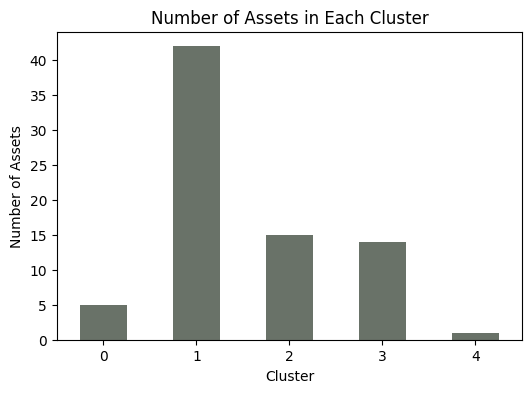

In [17]:
# Group assets by cluster and count the number of assets in each cluster
cluster_counts = representative_points['cluster'].value_counts().sort_index()

# Plot the number of assets in each cluster
plt.figure(figsize=(6, 4))
cluster_counts.plot(kind='bar', color=my_colors[1])
plt.xlabel('Cluster')
plt.ylabel('Number of Assets')
plt.title('Number of Assets in Each Cluster')
plt.xticks(rotation=0)
plt.show()

In [13]:
pca_to_plot_df = pca_to_plot_df.loc[:,:'PC2']
pca_to_plot_df.head()

,PC1,PC2
0,-1.163049,-2.596939
1,1.722822,-2.602608
2,1.451641,-2.588719
3,0.734407,-2.237956
4,0.121023,-2.182634


## K-Medoids (clara)

In [21]:
# # Define the parameter grid
# param_grid = {
#     'n_clusters': [2, 3, 4, 5, 10],
# }

# k_medoids_clust = CLARA(random_state=1)

# # Initialize GridSearchCV
# grid_search = GridSearchCV(k_medoids_clust, param_grid, scoring=silhouette_scorer, cv=2, verbose=2, n_jobs=-1)

# # Perform grid search
# grid_search.fit(pca_df)

In [22]:
# # Get the best parameters
# best_params = grid_search.best_params_
# print("Best Parameters:", best_params)

# # Get the best silhouette score
# best_score = grid_search.best_score_
# print("Best Silhouette Score:", best_score)

In [23]:
# pd.DataFrame(grid_search.cv_results_)

In [14]:
clara = CLARA(n_clusters=2, random_state=1)
clara.fit(pca_df)
labels = clara.predict(pca_df)

In [20]:
with open('results/partitional_opt/clara.pickle', 'wb') as f:
    pickle.dump(clara, f)

In [15]:
pca_to_plot_df['cluster_label'] = labels
pca_to_plot_df['asset_id'] = df_subset['asset_id']

pca_df['cluster_label'] = labels
pca_df['asset_id'] = df_subset['asset_id']

In [16]:
pca_df.to_csv('results/partitional_opt/csv_labels_raw/clara.csv', index=False)

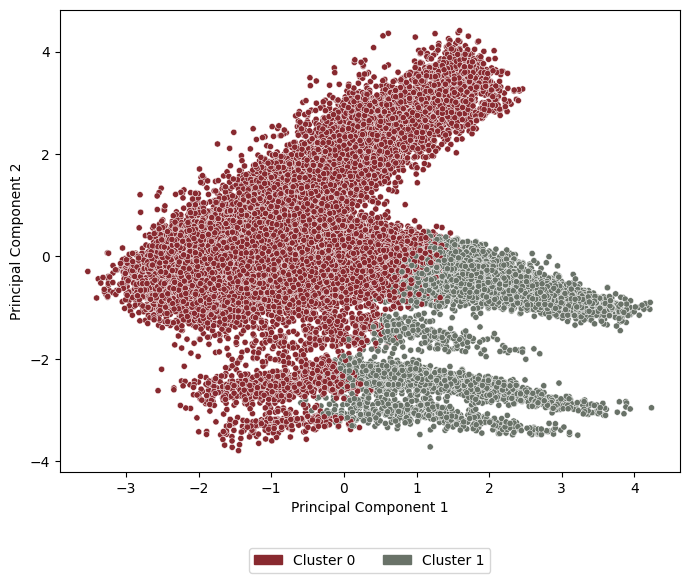

In [17]:
n_clusters = len(pca_to_plot_df['cluster_label'].unique())
pallete = sns.color_palette(my_colors, n_clusters)

# Plot the representative points on a scatter plot using PCA results
plt.figure(figsize=(8, 6))
sns.scatterplot(data=pca_to_plot_df, x='PC1', y='PC2', hue='cluster_label', palette=pallete, s=20)
# plt.title('K-Medoids (clara)')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
legend_handles = [mpatches.Circle((0, 0), radius=1, color=color) for color in my_colors]
plt.legend(handles=legend_handles, labels=[f'Cluster {cluster_label}' for cluster_label in np.unique(labels)],
            loc='upper center', bbox_to_anchor=(0.5, -0.15), ncol=5)
plt.show()

In [25]:
pca_to_plot_df['asset_id'] = df_subset['asset_id']

most_frequent_clusters = pca_to_plot_df.groupby('asset_id')['cluster_label'].agg(lambda x: np.bincount(x).argmax())

# Merge the most frequent cluster labels back to the original DataFrame
pca_to_plot_df = pca_to_plot_df.drop(columns='cluster_label')

pca_to_plot_df = pd.merge(pca_to_plot_df, most_frequent_clusters, on='asset_id', how='left')

pca_to_plot_df.head()

,PC1,PC2,asset_id,cluster_label
0,-1.163049,-2.596939,11,1
1,1.722822,-2.602608,11,1
2,1.451641,-2.588719,11,1
3,0.734407,-2.237956,11,1
4,0.121023,-2.182634,11,1


In [26]:
len(pca_to_plot_df['cluster_label'].unique())

2

In [27]:
pca_to_plot_df.to_csv('results/partitional_opt/labels_most_common/k_medoids_clara.csv', index=False)

In [28]:
# Group by asset_id and cluster, and select one representative point for each cluster
representative_points = pca_to_plot_df.groupby(['asset_id']).first().reset_index()
representative_points.head()

,asset_id,PC1,PC2,cluster_label
0,11,-1.163049,-2.596939,1
1,12,2.651199,-3.422293,1
2,13,1.451020,-0.049027,0
3,14,1.304045,-0.185737,0
4,15,2.222184,-0.592280,0


In [29]:
assets_clusters = representative_points.groupby('cluster_label')['asset_id']

# Print assets in each cluster
for cluster, assets in assets_clusters:
    print(f"Cluster {cluster}: {assets.index.tolist()}")

Cluster 0: [2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 53, 54, 55, 56, 57, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76]
Cluster 1: [0, 1, 52, 58]


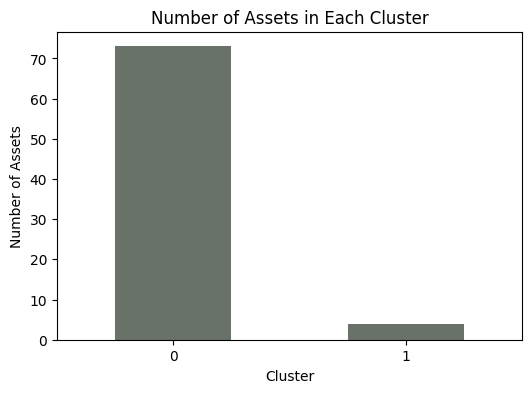

In [30]:
# Group assets by cluster and count the number of assets in each cluster
cluster_counts = representative_points['cluster_label'].value_counts().sort_index()

# Plot the number of assets in each cluster
plt.figure(figsize=(6, 4))
cluster_counts.plot(kind='bar', color=my_colors[1])
plt.xlabel('Cluster')
plt.ylabel('Number of Assets')
plt.title('Number of Assets in Each Cluster')
plt.xticks(rotation=0)
plt.show()

In [28]:
pca_to_plot_df = pca_to_plot_df.loc[:,:'PC2']

In [29]:
pca_df = pca_df.loc[:,:'PC4']

### Fuzzy C-Means

this one had to use the grid search method to get the optimized parameters due to the lack of this method in the NbClust

In [32]:
num_clusters = [2,3,5,10]
fuzziness_values = [0.5, 1.5, 2, 2.5]

best_combination = {}
best_score = 0

for cluster in num_clusters:
    for fuzziness in fuzziness_values:
        print(f'Testing {cluster} clusters and {fuzziness} fuzziness')
        cntr, u, u0, d, jm, p, fpc = fuzz.cluster.cmeans(
            pca_df.T, cluster, fuzziness, error=0.005, maxiter=1000, init=None)
        
        cluster_membership = u.T

        assigned_clusters = np.argmax(cluster_membership, axis=1)

        sil_score = silhouette_score(pca_df[['PC1', 'PC2']], assigned_clusters)
        davies_bouldin = davies_bouldin_score(pca_df[['PC1', 'PC2']], assigned_clusters)
        combined_score = 0.5 * sil_score + 0.5 * davies_bouldin

        if combined_score > best_score:
            print(f'Found a better clustering score: {combined_score}')
            best_score = combined_score
            best_combination = {'num_cluster':cluster,
                                'fuzziness': fuzziness}

print(f'The best clustering score was {best_score}\n with the parameters: \n {best_combination}')



Testing 2 clusters and 0.5 fuzziness
Found a better clustering score: 0.6897765847522882
Testing 2 clusters and 1.5 fuzziness
Found a better clustering score: 0.6940303256950231
Testing 2 clusters and 2 fuzziness
Testing 2 clusters and 2.5 fuzziness
Testing 3 clusters and 0.5 fuzziness
Testing 3 clusters and 1.5 fuzziness
Found a better clustering score: 0.7121177387510633
Testing 3 clusters and 2 fuzziness
Found a better clustering score: 0.7214561247477959
Testing 3 clusters and 2.5 fuzziness
Found a better clustering score: 0.727270412049534
Testing 5 clusters and 0.5 fuzziness
Testing 5 clusters and 1.5 fuzziness
Testing 5 clusters and 2 fuzziness
Testing 5 clusters and 2.5 fuzziness
Found a better clustering score: 1.2679640718293022
Testing 10 clusters and 0.5 fuzziness
Testing 10 clusters and 1.5 fuzziness
Testing 10 clusters and 2 fuzziness
Found a better clustering score: 1.6251836389817917
Testing 10 clusters and 2.5 fuzziness
Found a better clustering score: 2.27858011809821

In [30]:
# Define parameters
num_clusters = 10
fuzziness = 2.5

# Apply Fuzzy C-means clustering
cntr, u, u0, d, jm, p, fpc = fuzz.cluster.cmeans(
    pca_df.T, num_clusters, fuzziness, error=0.005, maxiter=1000, init=None)

# Extract cluster centroids
cluster_centroids = cntr.T

# Extract cluster membership probabilities
cluster_membership = u.T

# Assign data points to clusters based on membership probabilities
assigned_clusters = np.argmax(cluster_membership, axis=1)

In [34]:
data = {
    "cntr": cntr,
    "u": u,
    "u0": u0,
    "d": d,
    "jm": jm,
    "p": p,
    "fpc": fpc
}

# Open the file in write binary mode
with open('results/partitional_opt/fuzzy_c_means.pickle', "wb") as f:
    # Use pickle to dump the data dictionary into the file
    pickle.dump(data, f)

In [31]:
print(num_clusters)

pca_to_plot_df['cluster'] = assigned_clusters
pca_to_plot_df['asset_id'] = df_subset['asset_id']

pca_df['cluster'] = assigned_clusters
pca_df['asset_id'] = df_subset['asset_id']

10


In [32]:
pca_df.to_csv('results/partitional_opt/csv_labels_raw/fuzzy_c_means.csv', index = False)

In [33]:
pca_df = pca_df.loc[:,:'PC4']

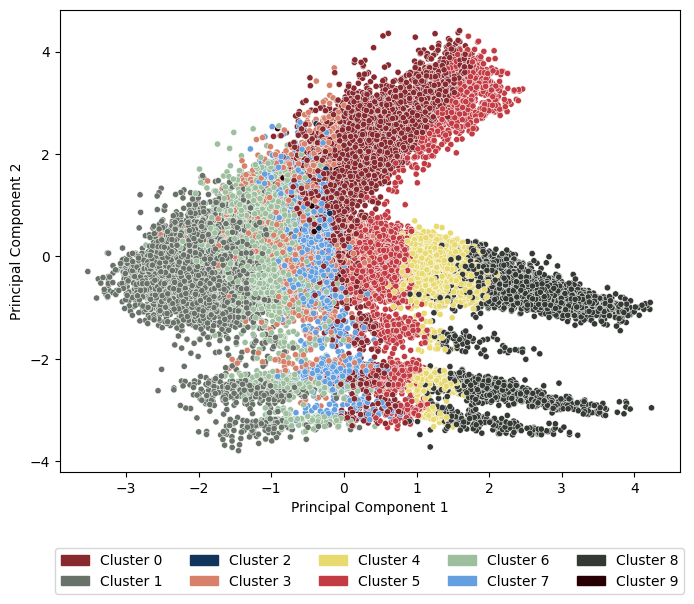

In [34]:
n_clusters = len(pca_to_plot_df['cluster'].unique())
pallete = sns.color_palette(my_colors, n_clusters)

# Plot the representative points on a scatter plot using PCA results
plt.figure(figsize=(8, 6))
sns.scatterplot(data=pca_to_plot_df, x='PC1', y='PC2', hue='cluster', palette=pallete, s=20)
# plt.title('Fuzzy C-Means')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
legend_handles = [mpatches.Circle((0, 0), radius=1, color=color) for color in my_colors]
plt.legend(handles=legend_handles, labels=[f'Cluster {cluster_label}' for cluster_label in np.unique(assigned_clusters)],
            loc='upper center', bbox_to_anchor=(0.5, -0.15), ncol=5)
plt.show()

In [35]:
most_frequent_clusters = pca_to_plot_df.groupby('asset_id')['cluster'].agg(lambda x: np.bincount(x).argmax())

# Merge the most frequent cluster labels back to the original DataFrame
pca_to_plot_df = pca_to_plot_df.drop(columns='cluster')

pca_to_plot_df = pd.merge(pca_to_plot_df, most_frequent_clusters, on='asset_id', how='left')

In [36]:
pca_to_plot_df.to_csv('results/partitional_opt/labels_most_common/fuzzy_c_means.csv', index = False)

In [37]:
# Group by asset_id and cluster, and select one representative point for each cluster
representative_points = pca_to_plot_df.groupby(['asset_id']).first().reset_index()
representative_points

,asset_id,PC1,PC2,cluster
0,11,-1.163049,-2.596939,8
1,12,2.651199,-3.422293,8
2,13,1.451020,-0.049027,4
3,14,1.304045,-0.185737,3
4,15,2.222184,-0.592280,3
...,...,...,...,...
72,510,0.207552,2.331831,0
73,511,1.209865,3.228942,0
74,512,-0.236960,0.793759,0
75,513,1.510521,3.365319,0


In [38]:
assets_clusters = pca_to_plot_df.groupby('asset_id')['cluster'].agg(lambda x: np.bincount(x).argmax())

# Print assets in each cluster
for cluster, assets in assets_clusters.groupby(assets_clusters):
    print(f"Cluster {cluster}: {assets.index.tolist()}")

Cluster 0: [51, 52, 53, 54, 55, 56, 57, 58, 59, 510, 511, 512, 513, 514]
Cluster 3: [14, 15, 16, 17, 18, 21, 22, 23, 24, 25, 26, 27, 28, 29, 32, 35, 37, 38, 39, 41, 42, 43, 44, 46, 49, 210, 211, 212, 213, 215, 217, 311, 313, 314, 315, 316, 317, 410, 411, 412, 413, 414, 415, 416, 417]
Cluster 4: [13, 31, 33, 34, 36, 110, 310]
Cluster 5: [45, 47, 48]
Cluster 8: [11, 12, 19, 111, 112, 214, 216, 312]


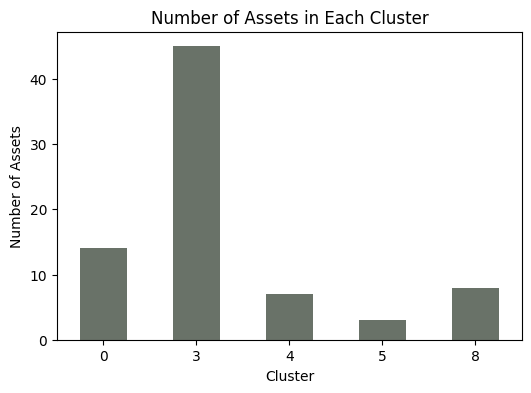

In [39]:
# Group assets by cluster and count the number of assets in each cluster
cluster_counts = assets_clusters.value_counts().sort_index()

# Plot the number of assets in each cluster
plt.figure(figsize=(6, 4))
cluster_counts.plot(kind='bar', color=my_colors[1])
plt.xlabel('Cluster')
plt.ylabel('Number of Assets')
plt.title('Number of Assets in Each Cluster')
plt.xticks(rotation=0)
plt.show()